<a href="https://colab.research.google.com/github/TristanDao/Report-ML---WINE-QUALITY-PREDICTION/blob/main/source_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Đồ án Máy Học - Phân tích và Dự đoán Chất lượng Rượu Vang

## Dataset: Wine Quality - UCI Machine Learning Repository


## 1. Import thư viện cần thiết


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from urllib.request import urlretrieve
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)

import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 2. Tải và Load dữ liệu


In [ ]:
# Tạo thư mục data nếu chưa có
if not os.path.exists('data'):
    os.makedirs('data')

# URLs của dataset
red_wine_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
white_wine_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# Tải dữ liệu nếu chưa có
if not os.path.exists('data/winequality-red.csv'):
    print('Đang tải dữ liệu wine đỏ...')
    urlretrieve(red_wine_url, 'data/winequality-red.csv')
    print('Đã tải xong!')

if not os.path.exists('data/winequality-white.csv'):
    print('Đang tải dữ liệu wine trắng...')
    urlretrieve(white_wine_url, 'data/winequality-white.csv')
    print('Đã tải xong!')

# Load dữ liệu
df_red = pd.read_csv('data/winequality-red.csv', sep=';')
df_white = pd.read_csv('data/winequality-white.csv', sep=';')

# Thêm cột loại rượu
df_red['wine_type'] = 'red'
df_white['wine_type'] = 'white'

# Gộp dữ liệu
df = pd.concat([df_red, df_white], ignore_index=True)

print(f"Kích thước dữ liệu: {df.shape}")
print(f"\nSố mẫu wine đỏ: {len(df_red)}")
print(f"Số mẫu wine trắng: {len(df_white)}")
print(f"\n5 dòng đầu tiên:")
df.head()

Đang tải dữ liệu wine đỏ...
Đã tải xong!
Đang tải dữ liệu wine trắng...
Đã tải xong!
Kích thước dữ liệu: (6497, 13)

Số mẫu wine đỏ: 1599
Số mẫu wine trắng: 4898

5 dòng đầu tiên:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


## 3. Phân tích dữ liệu (EDA)


### 3.1. Thống kê mô tả dữ liệu


In [ ]:
print("=== THỐNG KÊ MÔ TẢ DỮ LIỆU ===")
print(df.describe())
print("\n=== THÔNG TIN DỮ LIỆU ===")
print(df.info())
print("\n=== TÊN CÁC CỘT ===")
print(df.columns.tolist())

=== THỐNG KÊ MÔ TẢ DỮ LIỆU ===
       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.00900

In [ ]:
df.describe().T.style.background_gradient(axis=0)

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,6497.000000,7.215307,1.296434,3.800000,6.400000,7.000000,7.700000,15.900000
volatile_acidity,6497.000000,0.339666,0.164636,0.080000,0.230000,0.290000,0.400000,1.580000
citric_acid,6497.000000,0.318633,0.145318,0.000000,0.250000,0.310000,0.390000,1.660000
residual_sugar,6497.000000,5.443235,4.757804,0.600000,1.800000,3.000000,8.100000,65.800000
chlorides,6497.000000,0.056034,0.035034,0.009000,0.038000,0.047000,0.065000,0.611000
free_sulfur_dioxide,6497.000000,30.525319,17.749400,1.000000,17.000000,29.000000,41.000000,289.000000
total_sulfur_dioxide,6497.000000,115.744574,56.521855,6.000000,77.000000,118.000000,156.000000,440.000000
density,6497.000000,0.994697,0.002999,0.987110,0.992340,0.994890,0.996990,1.038980
pH,6497.000000,3.218501,0.160787,2.720000,3.110000,3.210000,3.320000,4.010000
sulphates,6497.000000,0.531268,0.148806,0.220000,0.430000,0.510000,0.600000,2.000000


### 3.2. Kiểm tra giá trị thiếu


In [ ]:
print("=== KIỂM TRA GIÁ TRỊ THIẾU ===")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Số lượng thiếu': missing_values,
    'Tỷ lệ %': missing_percent
})
print(missing_df[missing_df['Số lượng thiếu'] > 0])
if missing_df['Số lượng thiếu'].sum() == 0:
    print("\n✓ Không có giá trị thiếu trong dataset!")

=== KIỂM TRA GIÁ TRỊ THIẾU ===
Empty DataFrame
Columns: [Số lượng thiếu, Tỷ lệ %]
Index: []

✓ Không có giá trị thiếu trong dataset!


### 3.3. Phân bố của biến mục tiêu (quality)


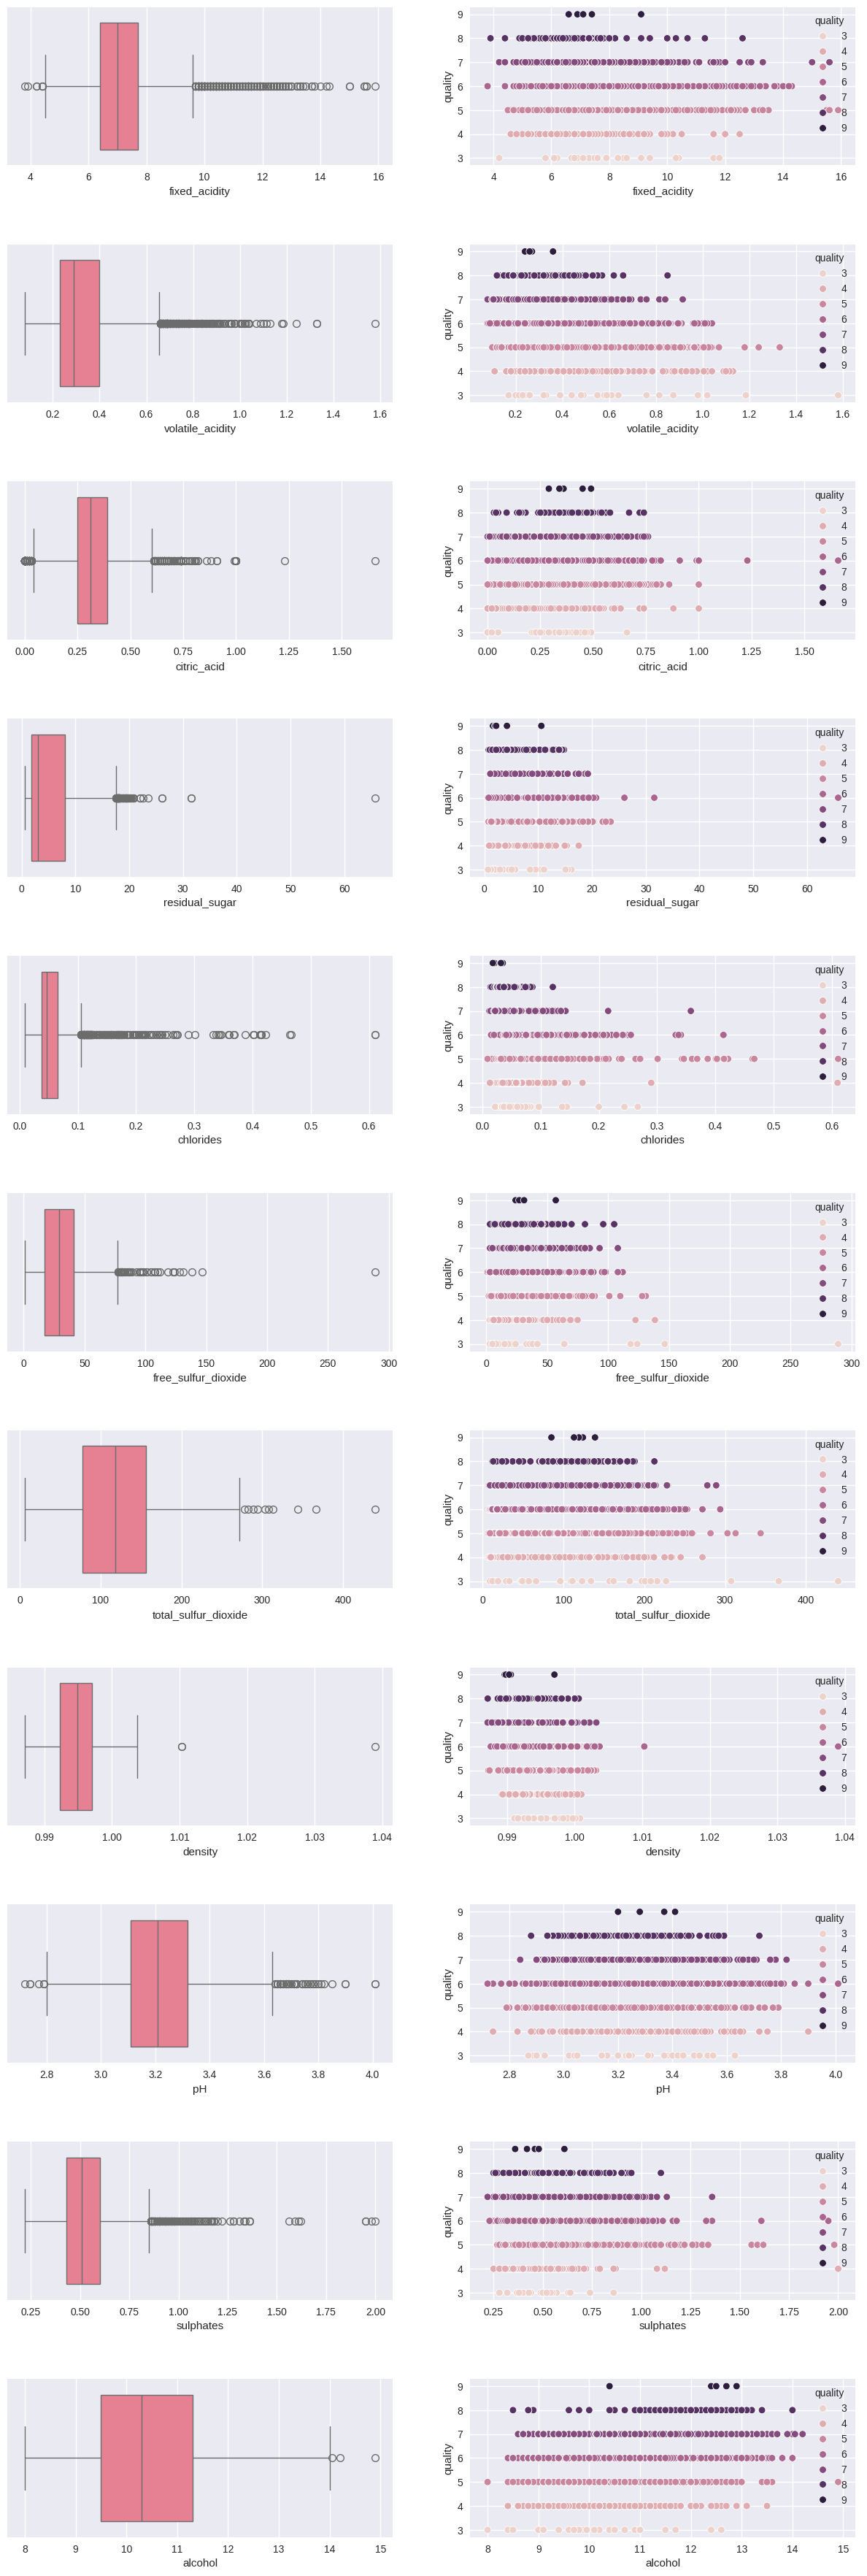

In [ ]:
df.rename(columns = {"fixed acidity": "fixed_acidity",
                       "volatile acidity": "volatile_acidity",
                       "citric acid": "citric_acid",
                       "residual sugar": "residual_sugar",
                       "chlorides": "chlorides",
                       "free sulfur dioxide": "free_sulfur_dioxide",
                       "total sulfur dioxide": "total_sulfur_dioxide"},
            inplace = True)

columns = list(df.columns)

fig, ax = plt.subplots(11, 2, figsize=(15, 45))
plt.subplots_adjust(hspace = 0.5)
for i in range(11) :
    # AX 1
    sns.boxplot(x=columns[i], data=df, ax=ax[i, 0])
    # Ax 2
    sns.scatterplot(x=columns[i], y='quality', data=df, hue='quality', ax=ax[i, 1])

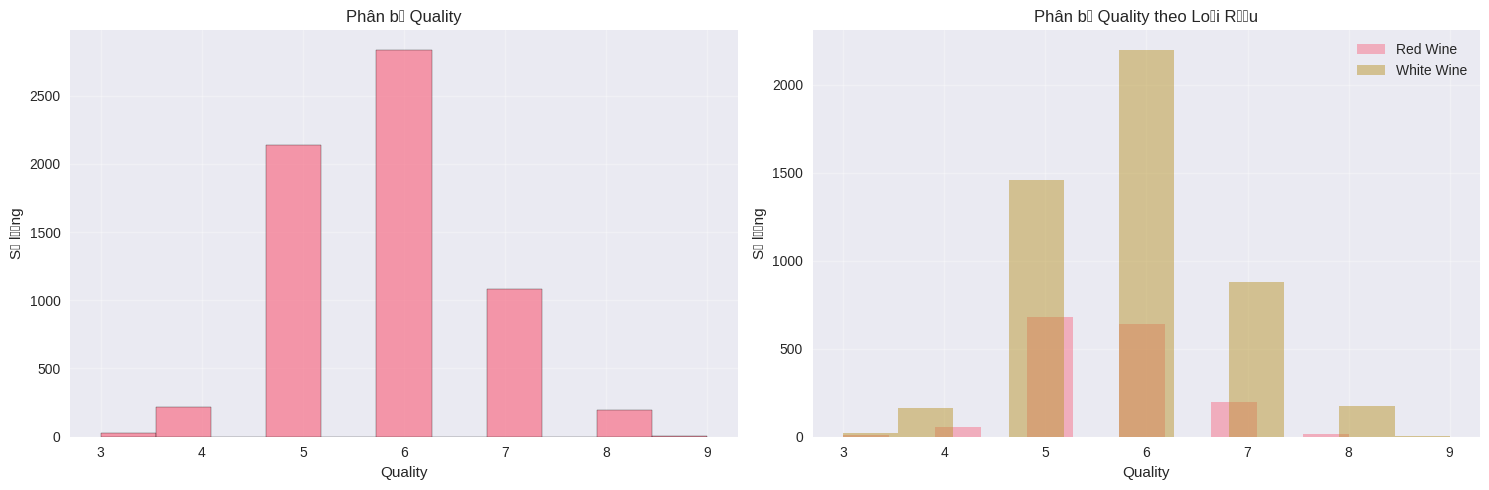


=== THỐNG KÊ QUALITY ===
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Phân bố quality
axes[0].hist(df['quality'], bins=11, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Quality')
axes[0].set_ylabel('Số lượng')
axes[0].set_title('Phân bố Quality')
axes[0].grid(True, alpha=0.3)

# Phân bố quality theo loại rượu
df_red['quality'].hist(alpha=0.5, label='Red Wine', bins=11, ax=axes[1])
df_white['quality'].hist(alpha=0.5, label='White Wine', bins=11, ax=axes[1])
axes[1].set_xlabel('Quality')
axes[1].set_ylabel('Số lượng')
axes[1].set_title('Phân bố Quality theo Loại Rượu')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== THỐNG KÊ QUALITY ===")
print(df['quality'].value_counts().sort_index())

### 3.4. Phân bố các đặc trưng


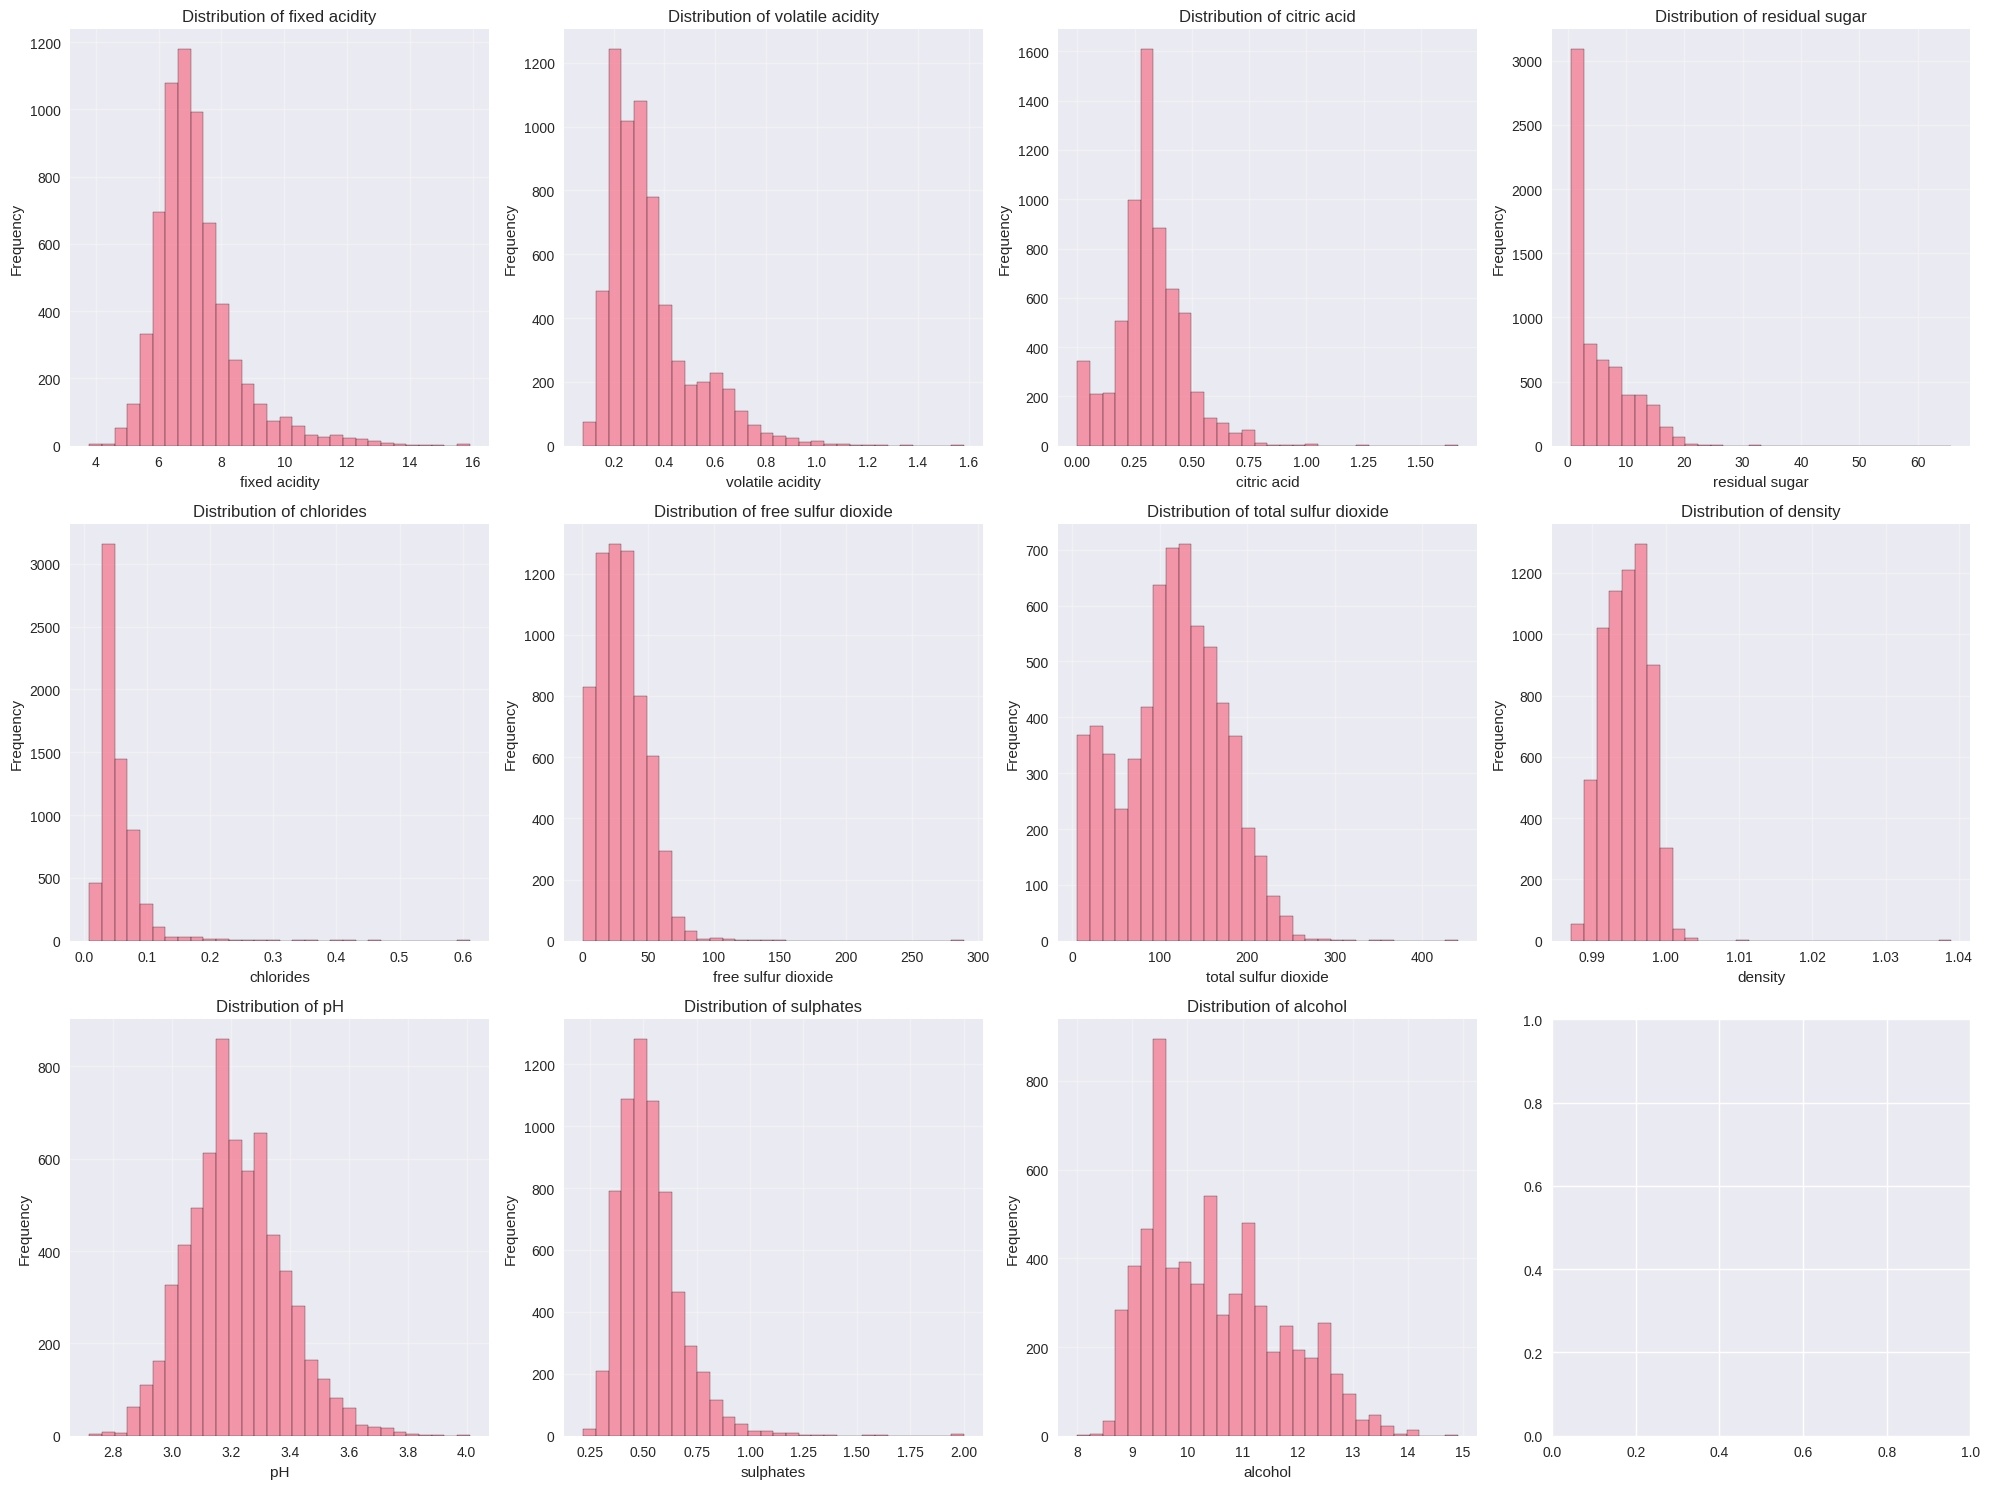

In [ ]:
features = [col for col in df.columns if col not in ['quality', 'wine_type']]

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].hist(df[feature], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.5. Ma trận tương quan


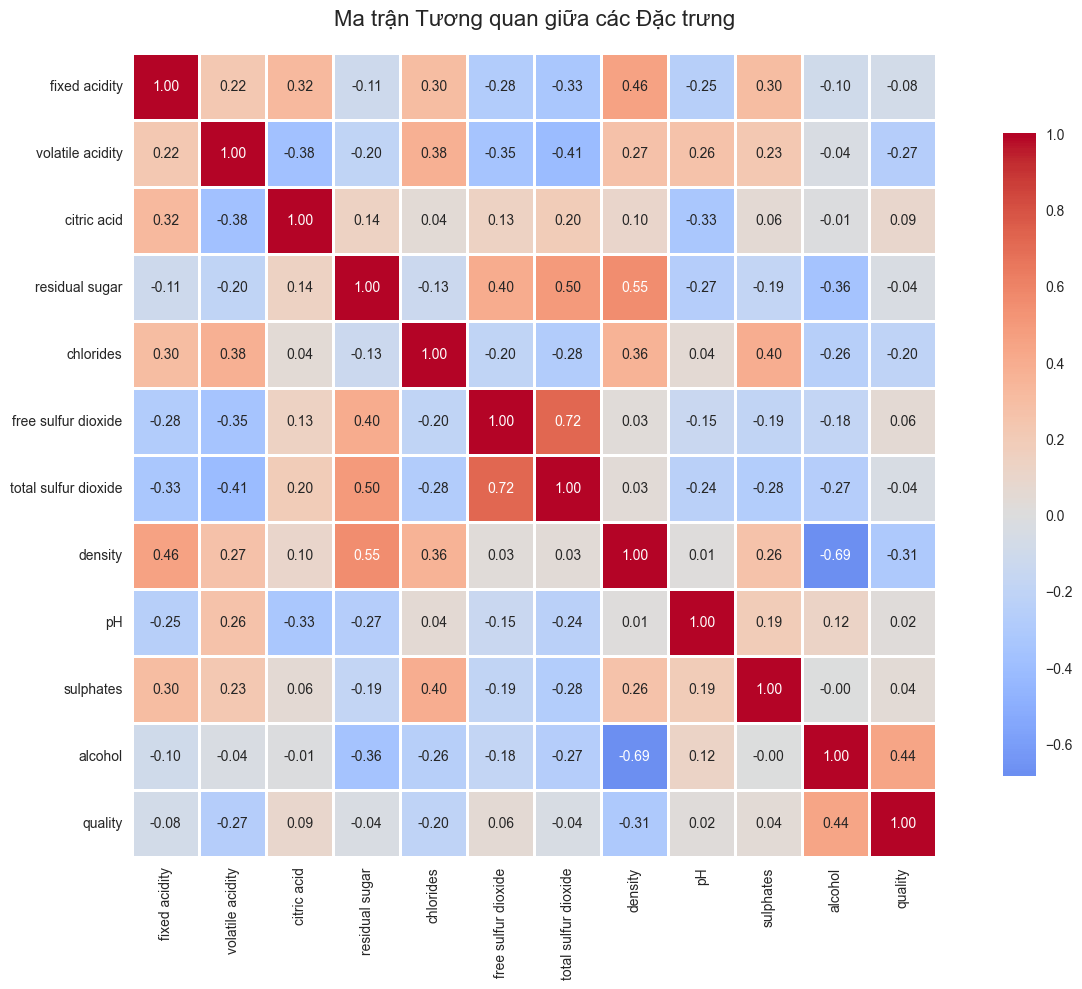


=== TƯƠNG QUAN VỚI QUALITY ===
quality                 1.000000
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64


In [ ]:
plt.figure(figsize=(14, 10))
correlation_matrix = df[features + ['quality']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma trận Tương quan giữa các Đặc trưng', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Tương quan với quality
print("\n=== TƯƠNG QUAN VỚI QUALITY ===")
corr_with_quality = correlation_matrix['quality'].sort_values(ascending=False)
print(corr_with_quality)


### 3.6. Phân tích mất cân bằng lớp


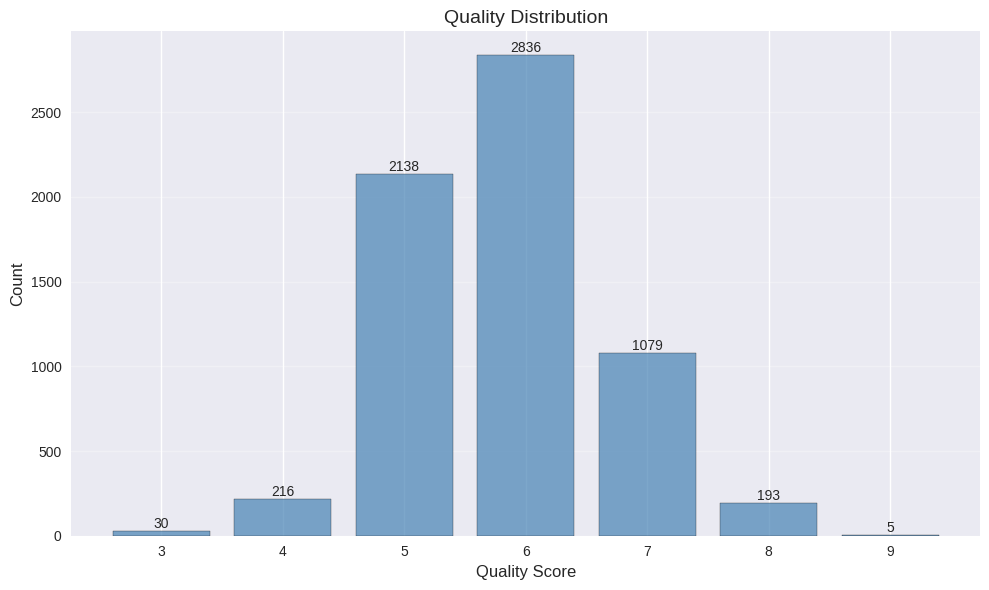


=== PHÂN TÍCH MẤT CÂN BẰNG ===
Tỷ lệ mẫu quality 5: 32.91%
Tỷ lệ mẫu quality 6: 43.65%
Tỷ lệ mẫu quality 7: 16.61%

→ Dataset bị mất cân bằng, quality 5 và 6 chiếm đa số.


In [ ]:
quality_counts = df['quality'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(quality_counts.index, quality_counts.values,
               color='steelblue', edgecolor='black', alpha=0.7)

# Thay đổi nhãn sang tiếng Anh
plt.xlabel('Quality Score')
plt.ylabel('Count') # Hoặc 'Number of Samples'
plt.title('Quality Distribution') # Hoặc giữ nguyên 'Quality'
plt.grid(True, alpha=0.3, axis='y')

# Thêm nhãn số trên mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


print("\n=== PHÂN TÍCH MẤT CÂN BẰNG ===")
print(f"Tỷ lệ mẫu quality 5: {quality_counts.get(5, 0) / len(df) * 100:.2f}%")
print(f"Tỷ lệ mẫu quality 6: {quality_counts.get(6, 0) / len(df) * 100:.2f}%")
print(f"Tỷ lệ mẫu quality 7: {quality_counts.get(7, 0) / len(df) * 100:.2f}%")
print(f"\n→ Dataset bị mất cân bằng, quality 5 và 6 chiếm đa số.")


## 4. Tiền xử lý dữ liệu


### 4.1. Chuyển quality thành nhãn phân loại nhị phân


=== BINARY LABEL DISTRIBUTION ===
quality_binary
1    4113
0    2384
Name: count, dtype: int64

Low Quality Ratio: 36.69%
High Quality Ratio: 63.31%


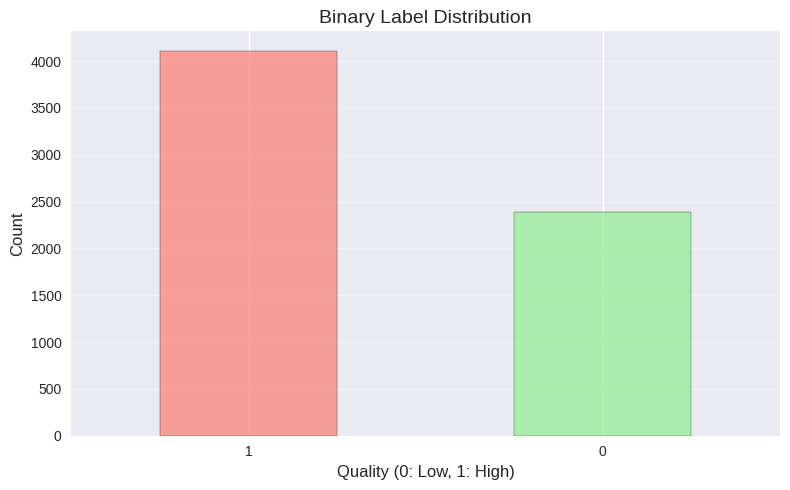

In [ ]:
# Tạo bản sao để không ảnh hưởng dữ liệu gốc
df_processed = df.copy()

# Chuyển quality thành nhãn nhị phân
# 0 → chất lượng thấp (quality ≤ 5)
# 1 → chất lượng cao (quality ≥ 6)
df_processed['quality_binary'] = (df_processed['quality'] >= 6).astype(int)

# Chuyển đổi nội dung in ra console
print("=== BINARY LABEL DISTRIBUTION ===")
print(df_processed['quality_binary'].value_counts())
print(f"\nLow Quality Ratio: {(df_processed['quality_binary'] == 0).sum() / len(df_processed) * 100:.2f}%")
print(f"High Quality Ratio: {(df_processed['quality_binary'] == 1).sum() / len(df_processed) * 100:.2f}%")

plt.figure(figsize=(8, 5))
df_processed['quality_binary'].value_counts().plot(kind='bar', color=['salmon', 'lightgreen'],
                                                   edgecolor='black', alpha=0.7)

# Chuyển đổi nhãn biểu đồ sang tiếng Anh
plt.xlabel('Quality (0: Low, 1: High)')
plt.ylabel('Count')
plt.title('Binary Label Distribution')

plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


### 4.2. Xử lý outliers bằng IQR method


In [ ]:
def remove_outliers_iqr(df, columns):
    """Loại bỏ outliers sử dụng phương pháp IQR"""
    df_clean = df.copy()
    initial_count = len(df_clean)

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    removed_count = initial_count - len(df_clean)
    print(f"Đã loại bỏ {removed_count} mẫu outliers ({removed_count/initial_count*100:.2f}%)")
    return df_clean

# Chọn các đặc trưng để xử lý outliers (không bao gồm quality và wine_type)
feature_cols = [col for col in df_processed.columns if col not in ['quality', 'wine_type', 'quality_binary']]

# Loại bỏ outliers
df_processed = remove_outliers_iqr(df_processed, feature_cols)
print(f"Kích thước dữ liệu sau khi xử lý outliers: {df_processed.shape}")


Đã loại bỏ 1901 mẫu outliers (29.26%)
Kích thước dữ liệu sau khi xử lý outliers: (4596, 14)


### 4.3. Chuẩn hóa dữ liệu và chia train/test


In [ ]:
# Chuẩn bị dữ liệu
X = df_processed[feature_cols].copy()
y = df_processed['quality_binary'].copy()

# Thử nghiệm với nhiều tỷ lệ train/test
test_sizes = [0.1, 0.2, 0.3]
results_summary = {}

print("=== CHUẨN HÓA VÀ CHIA DỮ LIỆU ===")
print(f"Tổng số mẫu: {len(X)}")
print(f"Số đặc trưng: {len(feature_cols)}")

# Lưu các scaler và dataset cho từng tỷ lệ
datasets = {}

for test_size in test_sizes:
    # Chia train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # Chuẩn hóa dữ liệu (sử dụng StandardScaler)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    datasets[test_size] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': feature_cols
    }

    print(f"\nTest size = {test_size}:")
    print(f"  Train: {len(X_train_scaled)} mẫu")
    print(f"  Test: {len(X_test_scaled)} mẫu")

# Sử dụng test_size = 0.2 làm mặc định cho các phần tiếp theo
X_train = datasets[0.2]['X_train']
X_test = datasets[0.2]['X_test']
y_train = datasets[0.2]['y_train']
y_test = datasets[0.2]['y_test']
feature_names = datasets[0.2]['feature_names']


=== CHUẨN HÓA VÀ CHIA DỮ LIỆU ===
Tổng số mẫu: 4596
Số đặc trưng: 11

Test size = 0.1:
  Train: 4136 mẫu
  Test: 460 mẫu

Test size = 0.2:
  Train: 3676 mẫu
  Test: 920 mẫu

Test size = 0.3:
  Train: 3217 mẫu
  Test: 1379 mẫu


## 5. Xây dựng và Đánh giá Mô hình


### 5.1. Hàm đánh giá mô hình


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Đánh giá mô hình với các metrics"""
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # ROC AUC
    roc_auc = None
    if y_test_proba is not None:
        roc_auc = roc_auc_score(y_test, y_test_proba)

    results = {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_test_proba': y_test_proba,
        'model': model
    }

    return results

def plot_confusion_matrix(cm, model_name):
    """Vẽ confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Chất lượng thấp', 'Chất lượng cao'],
                yticklabels=['Chất lượng thấp', 'Chất lượng cao'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Thực tế')
    plt.xlabel('Dự đoán')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_test, y_proba, model_name, roc_auc):
    """Vẽ ROC curve"""
    if y_proba is None:
        return

    fpr, tpr, _ = roc_curve(y_test, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### 5.2. Logistic Regression (Baseline)


=== LOGISTIC REGRESSION ===
Train Accuracy: 0.7454
Test Accuracy: 0.7424
Precision: 0.7734
Recall: 0.8806
F1-Score: 0.8235
ROC AUC: 0.7915


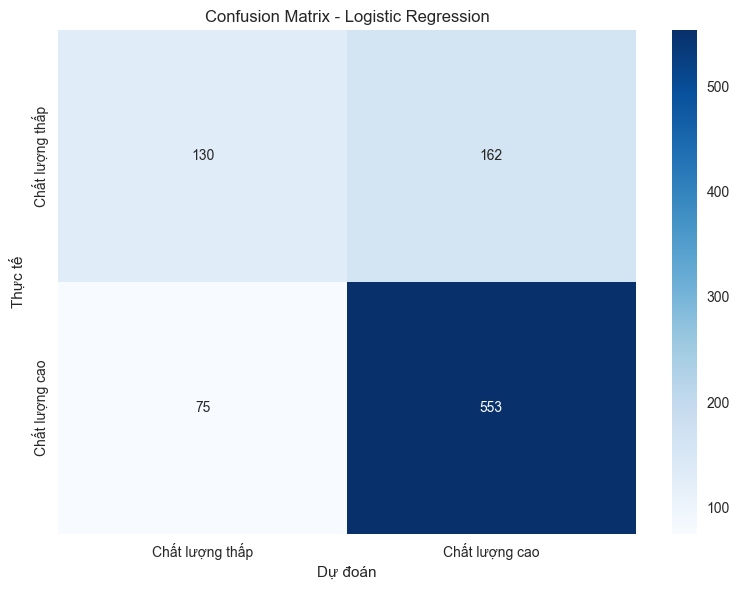

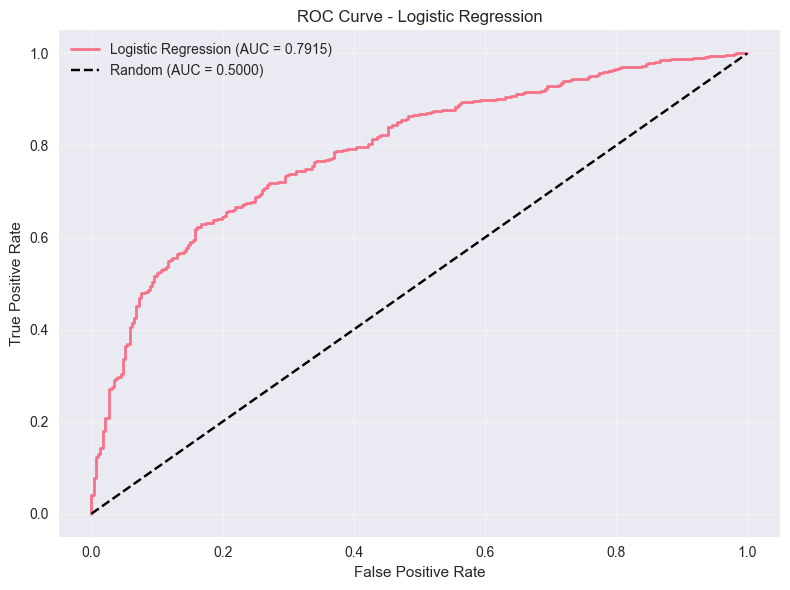

In [ ]:
print("=== LOGISTIC REGRESSION ===")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test, 'Logistic Regression')

print(f"Train Accuracy: {lr_results['train_accuracy']:.4f}")
print(f"Test Accuracy: {lr_results['test_accuracy']:.4f}")
print(f"Precision: {lr_results['precision']:.4f}")
print(f"Recall: {lr_results['recall']:.4f}")
print(f"F1-Score: {lr_results['f1_score']:.4f}")
print(f"ROC AUC: {lr_results['roc_auc']:.4f}")

plot_confusion_matrix(lr_results['confusion_matrix'], 'Logistic Regression')
plot_roc_curve(y_test, lr_results['y_test_proba'], 'Logistic Regression', lr_results['roc_auc'])


### 5.3. Decision Tree


=== DECISION TREE ===
Train Accuracy: 0.8928
Test Accuracy: 0.7543
Precision: 0.8121
Recall: 0.8328
F1-Score: 0.8223
ROC AUC: 0.7776


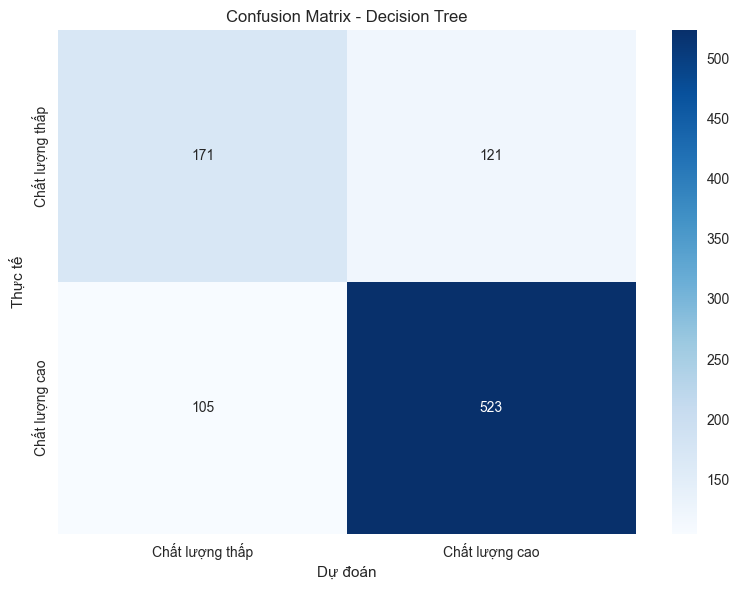

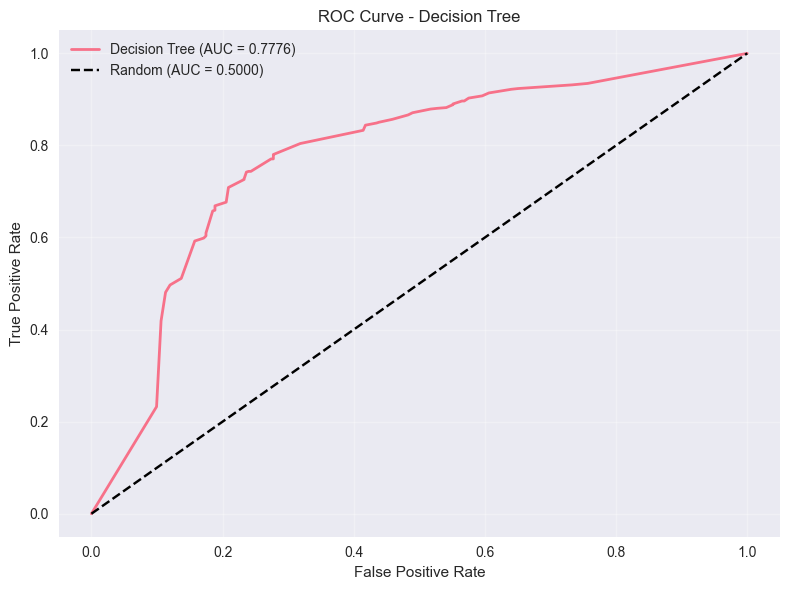

In [ ]:
print("=== DECISION TREE ===")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_results = evaluate_model(dt_model, X_train, X_test, y_train, y_test, 'Decision Tree')

print(f"Train Accuracy: {dt_results['train_accuracy']:.4f}")
print(f"Test Accuracy: {dt_results['test_accuracy']:.4f}")
print(f"Precision: {dt_results['precision']:.4f}")
print(f"Recall: {dt_results['recall']:.4f}")
print(f"F1-Score: {dt_results['f1_score']:.4f}")
print(f"ROC AUC: {dt_results['roc_auc']:.4f}")

plot_confusion_matrix(dt_results['confusion_matrix'], 'Decision Tree')
plot_roc_curve(y_test, dt_results['y_test_proba'], 'Decision Tree', dt_results['roc_auc'])


### 5.4. LightGBM


=== LIGHTGBM ===
Train Accuracy: 0.9616
Test Accuracy: 0.8217
Precision: 0.8591
Recall: 0.8838
F1-Score: 0.8713
ROC AUC: 0.8793


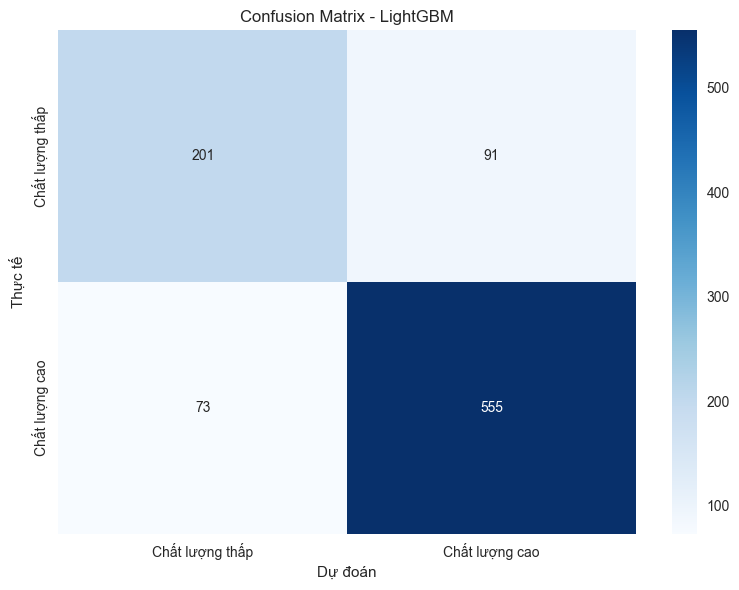

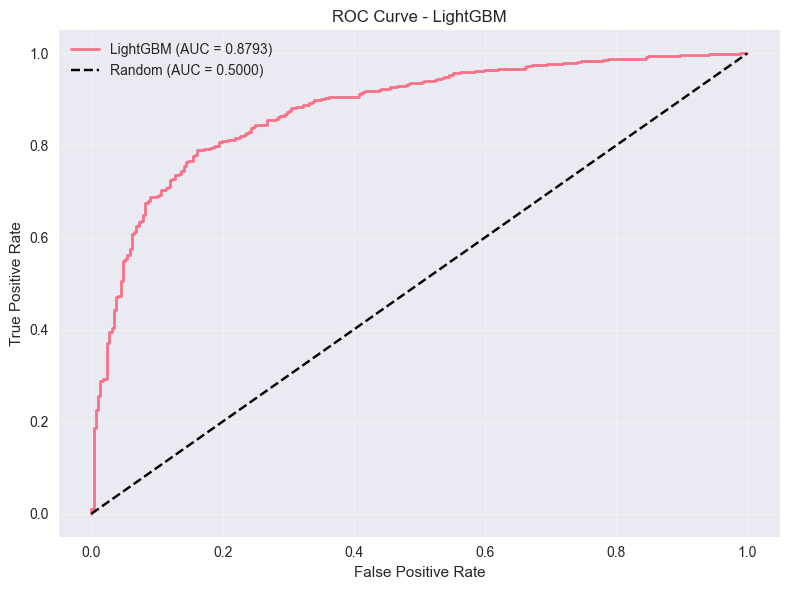

In [ ]:
print("=== LIGHTGBM ===")
lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
lgb_results = evaluate_model(lgb_model, X_train, X_test, y_train, y_test, 'LightGBM')

print(f"Train Accuracy: {lgb_results['train_accuracy']:.4f}")
print(f"Test Accuracy: {lgb_results['test_accuracy']:.4f}")
print(f"Precision: {lgb_results['precision']:.4f}")
print(f"Recall: {lgb_results['recall']:.4f}")
print(f"F1-Score: {lgb_results['f1_score']:.4f}")
print(f"ROC AUC: {lgb_results['roc_auc']:.4f}")

plot_confusion_matrix(lgb_results['confusion_matrix'], 'LightGBM')
plot_roc_curve(y_test, lgb_results['y_test_proba'], 'LightGBM', lgb_results['roc_auc'])


### 5.5. XGBoost


=== XGBOOST ===
Train Accuracy: 0.9937
Test Accuracy: 0.8141
Precision: 0.8499
Recall: 0.8838
F1-Score: 0.8665
ROC AUC: 0.8735


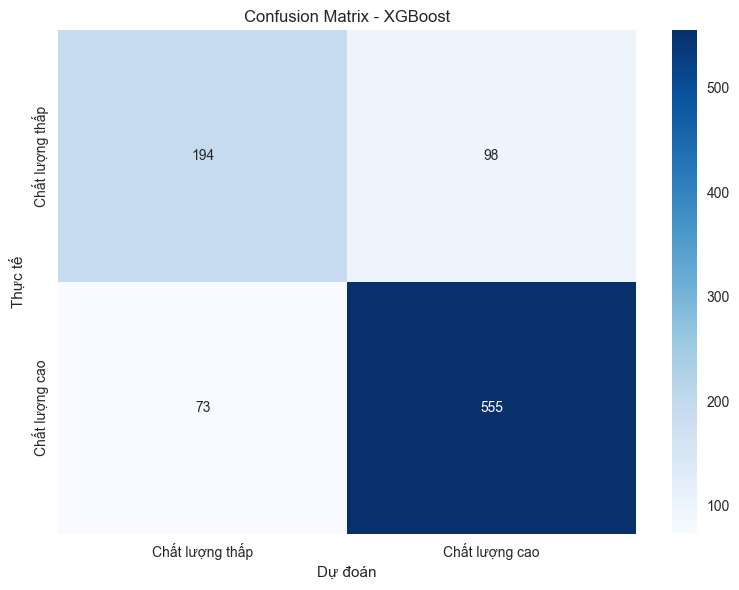

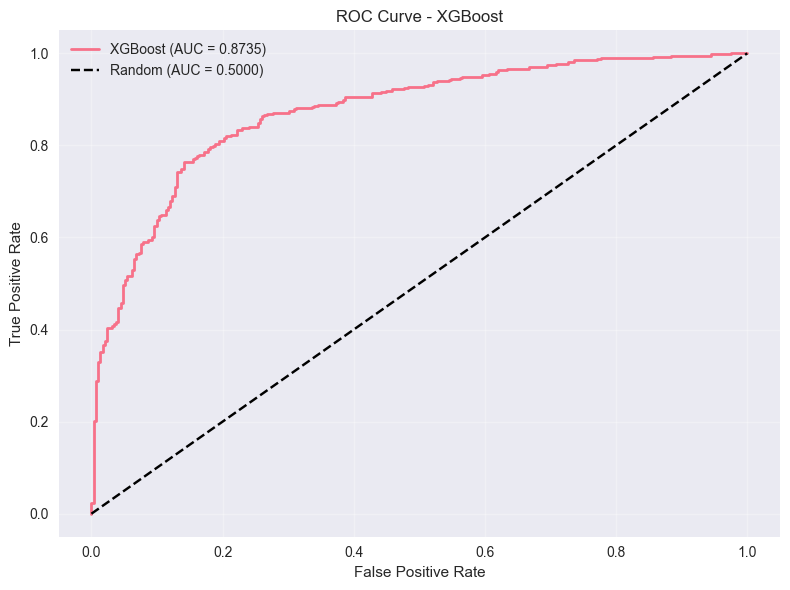

In [ ]:
print("=== XGBOOST ===")
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, 'XGBoost')

print(f"Train Accuracy: {xgb_results['train_accuracy']:.4f}")
print(f"Test Accuracy: {xgb_results['test_accuracy']:.4f}")
print(f"Precision: {xgb_results['precision']:.4f}")
print(f"Recall: {xgb_results['recall']:.4f}")
print(f"F1-Score: {xgb_results['f1_score']:.4f}")
print(f"ROC AUC: {xgb_results['roc_auc']:.4f}")

plot_confusion_matrix(xgb_results['confusion_matrix'], 'XGBoost')
plot_roc_curve(y_test, xgb_results['y_test_proba'], 'XGBoost', xgb_results['roc_auc'])


### 5.6. So sánh hiệu suất các mô hình


=== SO SÁNH HIỆU SUẤT CÁC MÔ HÌNH ===
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score  ROC AUC
Logistic Regression        0.745375       0.742391   0.773427 0.880573  0.823529 0.791467
      Decision Tree        0.892818       0.754348   0.812112 0.832803  0.822327 0.777626
           LightGBM        0.961643       0.821739   0.859133 0.883758  0.871272 0.879324
            XGBoost        0.993743       0.814130   0.849923 0.883758  0.866511 0.873484


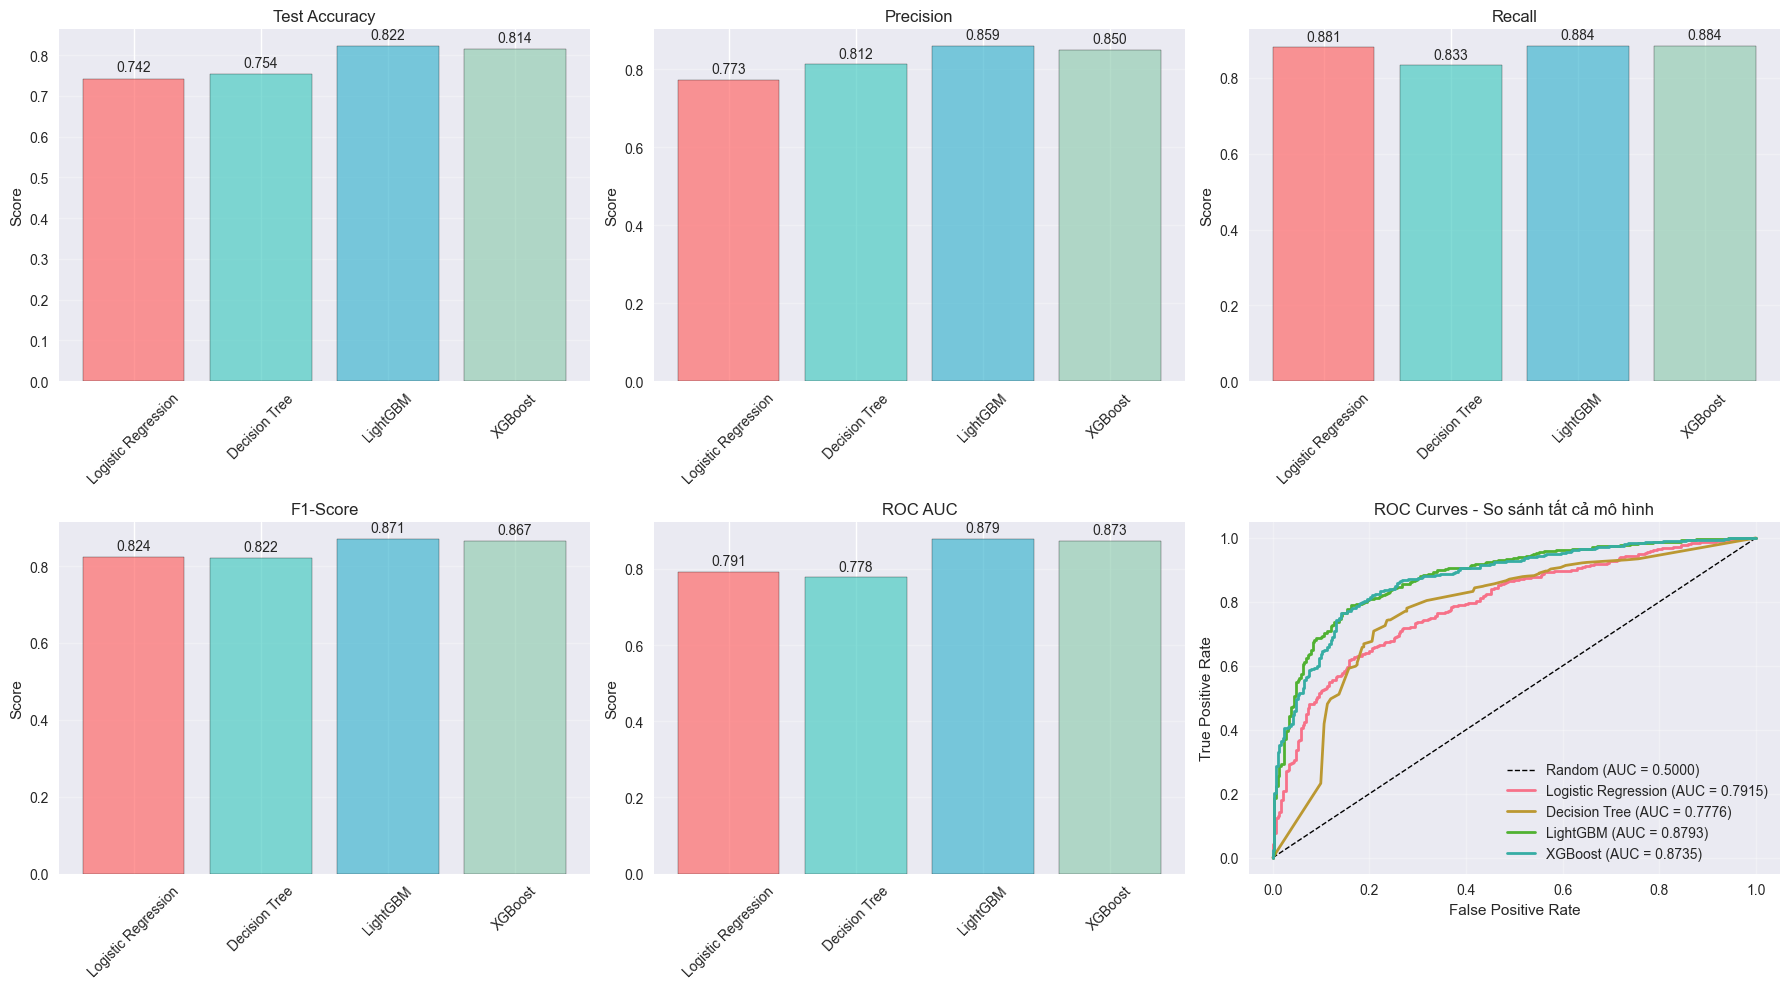


✓ Mô hình tốt nhất (theo Test Accuracy): LightGBM
  Test Accuracy: 0.8217


In [ ]:
# Tổng hợp kết quả
all_results = [lr_results, dt_results, lgb_results, xgb_results]

comparison_df = pd.DataFrame({
    'Model': [r['model_name'] for r in all_results],
    'Train Accuracy': [r['train_accuracy'] for r in all_results],
    'Test Accuracy': [r['test_accuracy'] for r in all_results],
    'Precision': [r['precision'] for r in all_results],
    'Recall': [r['recall'] for r in all_results],
    'F1-Score': [r['f1_score'] for r in all_results],
    'ROC AUC': [r['roc_auc'] if r['roc_auc'] else 0 for r in all_results]
})

print("=== SO SÁNH HIỆU SUẤT CÁC MÔ HÌNH ===")
print(comparison_df.to_string(index=False))

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df['Model'], comparison_df[metric],
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3, axis='y')

    # Thêm giá trị trên mỗi cột
    for j, v in enumerate(comparison_df[metric]):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Vẽ ROC curves cho tất cả mô hình
axes[5].plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)', linewidth=1)
for result in all_results:
    if result['y_test_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_test_proba'])
        axes[5].plot(fpr, tpr, label=f"{result['model_name']} (AUC = {result['roc_auc']:.4f})", linewidth=2)
axes[5].set_xlabel('False Positive Rate')
axes[5].set_ylabel('True Positive Rate')
axes[5].set_title('ROC Curves - So sánh tất cả mô hình')
axes[5].legend()
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm mô hình tốt nhất
best_model_idx = comparison_df['Test Accuracy'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\n✓ Mô hình tốt nhất (theo Test Accuracy): {best_model}")
print(f"  Test Accuracy: {comparison_df.loc[best_model_idx, 'Test Accuracy']:.4f}")


## 6. Phân tích Feature Importance


### 6.1. Feature Importance - XGBoost


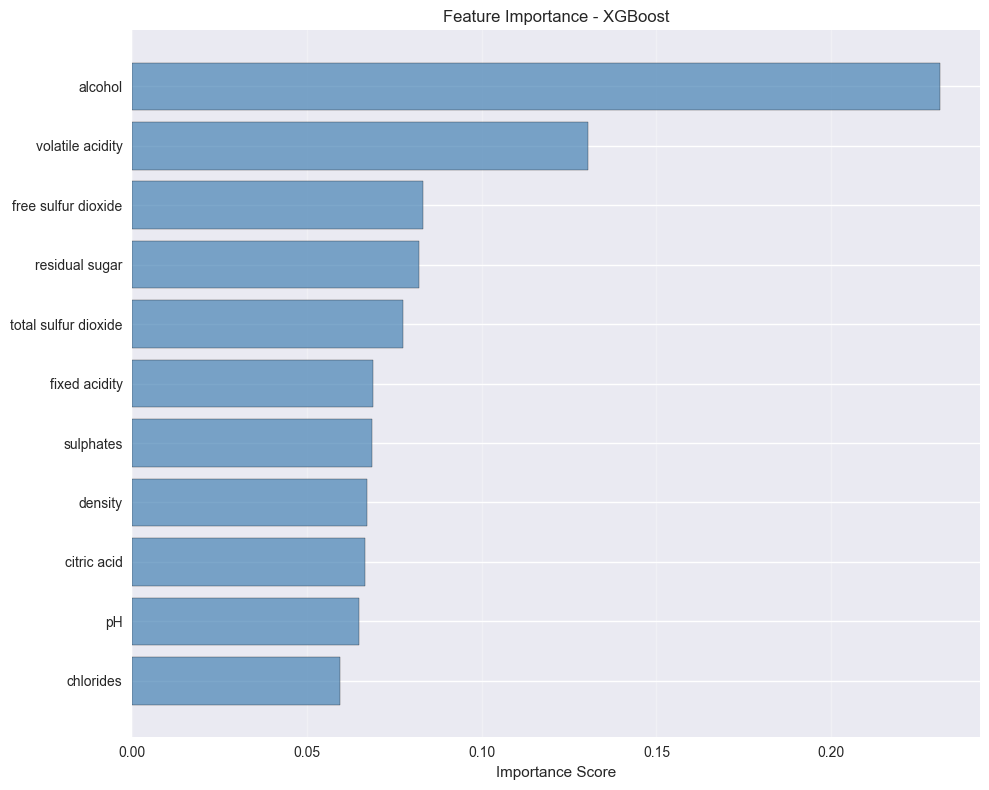

=== TOP 5 ĐẶC TRƯNG QUAN TRỌNG NHẤT (XGBoost) ===
             Feature  Importance
             alcohol    0.231022
    volatile acidity    0.130474
 free sulfur dioxide    0.083319
      residual sugar    0.082148
total sulfur dioxide    0.077500


In [ ]:
xgb_importance = xgb_model.feature_importances_
xgb_feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(xgb_feature_imp_df['Feature'], xgb_feature_imp_df['Importance'],
        color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Importance Score')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("=== TOP 5 ĐẶC TRƯNG QUAN TRỌNG NHẤT (XGBoost) ===")
print(xgb_feature_imp_df.head().to_string(index=False))


### 6.2. Feature Importance - LightGBM


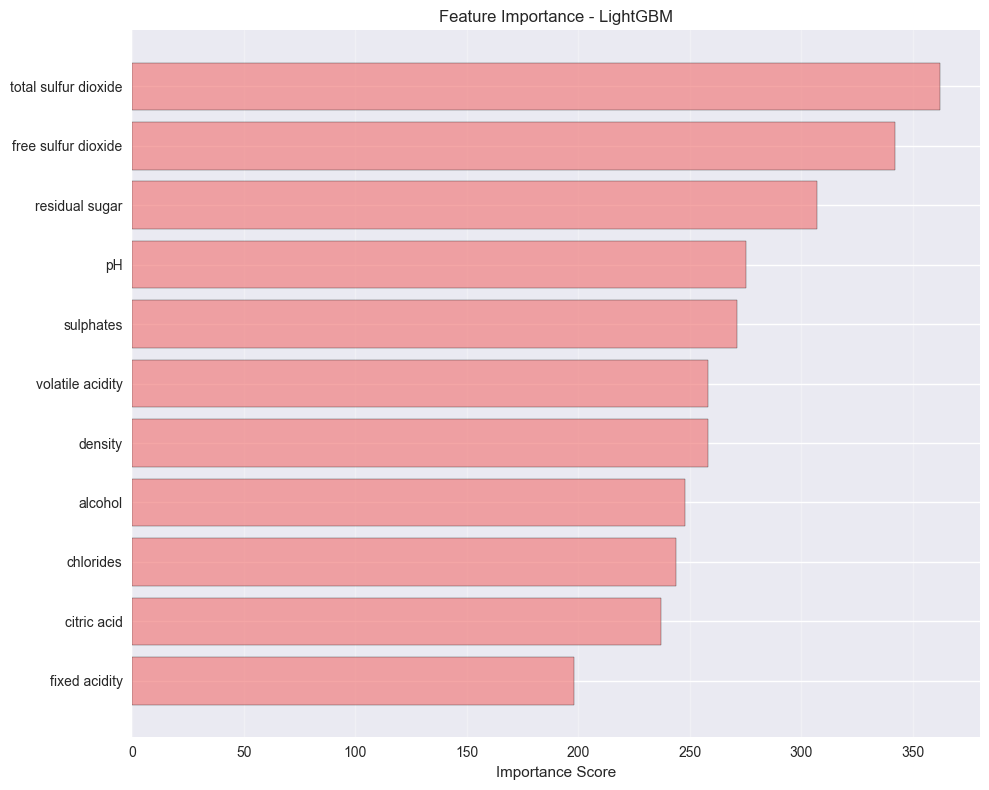

=== TOP 5 ĐẶC TRƯNG QUAN TRỌNG NHẤT (LightGBM) ===
             Feature  Importance
total sulfur dioxide         362
 free sulfur dioxide         342
      residual sugar         307
                  pH         275
           sulphates         271


In [ ]:
lgb_importance = lgb_model.feature_importances_
lgb_feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgb_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(lgb_feature_imp_df['Feature'], lgb_feature_imp_df['Importance'],
        color='lightcoral', edgecolor='black', alpha=0.7)
plt.xlabel('Importance Score')
plt.title('Feature Importance - LightGBM')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("=== TOP 5 ĐẶC TRƯNG QUAN TRỌNG NHẤT (LightGBM) ===")
print(lgb_feature_imp_df.head().to_string(index=False))


### 6.3. So sánh Feature Importance giữa XGBoost và LightGBM


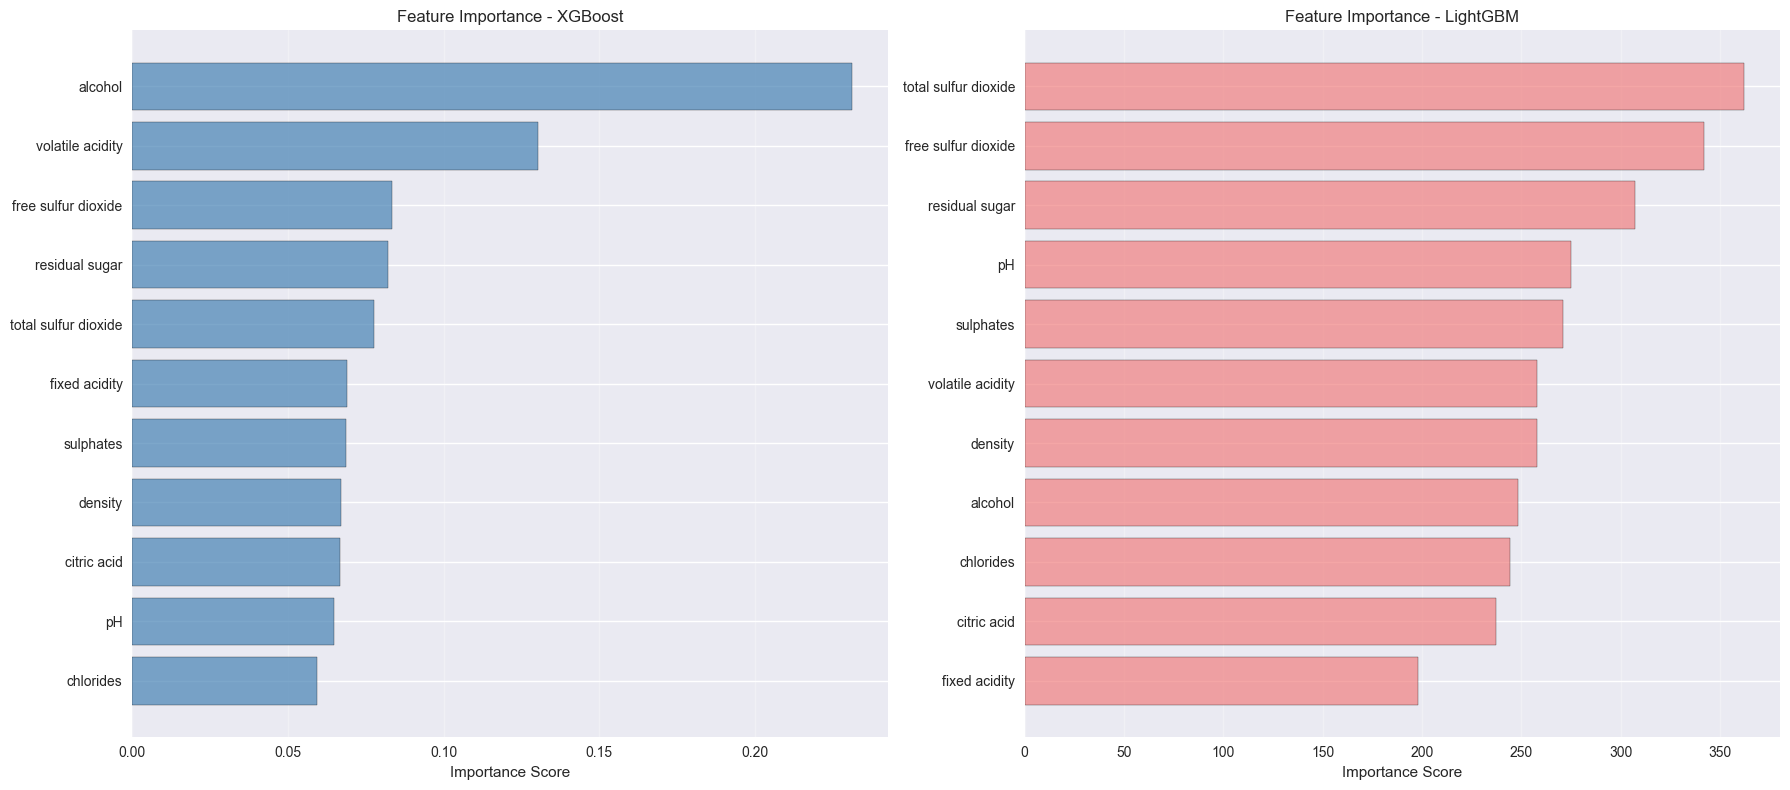

=== NHẬN XÉT ===

Các đặc trưng quan trọng nhất thường là:
- alcohol: Nồng độ cồn ảnh hưởng trực tiếp đến chất lượng rượu
- volatile acidity: Axit dễ bay hơi, nếu quá cao sẽ làm rượu có mùi khó chịu
- sulphates: Sulfat giúp bảo quản rượu, ảnh hưởng đến chất lượng
- total sulfur dioxide: Tổng lượng SO2, ảnh hưởng đến hương vị
- density: Mật độ rượu, liên quan đến nồng độ cồn và đường


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# XGBoost
axes[0].barh(xgb_feature_imp_df['Feature'], xgb_feature_imp_df['Importance'],
           color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Feature Importance - XGBoost')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# LightGBM
axes[1].barh(lgb_feature_imp_df['Feature'], lgb_feature_imp_df['Importance'],
           color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Importance Score')
axes[1].set_title('Feature Importance - LightGBM')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("=== NHẬN XÉT ===")
print("\nCác đặc trưng quan trọng nhất thường là:")
print("- alcohol: Nồng độ cồn ảnh hưởng trực tiếp đến chất lượng rượu")
print("- volatile acidity: Axit dễ bay hơi, nếu quá cao sẽ làm rượu có mùi khó chịu")
print("- sulphates: Sulfat giúp bảo quản rượu, ảnh hưởng đến chất lượng")
print("- total sulfur dioxide: Tổng lượng SO2, ảnh hưởng đến hương vị")
print("- density: Mật độ rượu, liên quan đến nồng độ cồn và đường")


## 7. Thực nghiệm với nhiều tỷ lệ train/test


=== THỰC NGHIỆM VỚI NHIỀU TỶ LỆ TRAIN/TEST ===

--- Test Size = 0.1 ---
Accuracy: 0.8587
F1-Score: 0.8967

--- Test Size = 0.2 ---
Accuracy: 0.8141
F1-Score: 0.8665

--- Test Size = 0.3 ---
Accuracy: 0.8325
F1-Score: 0.8806


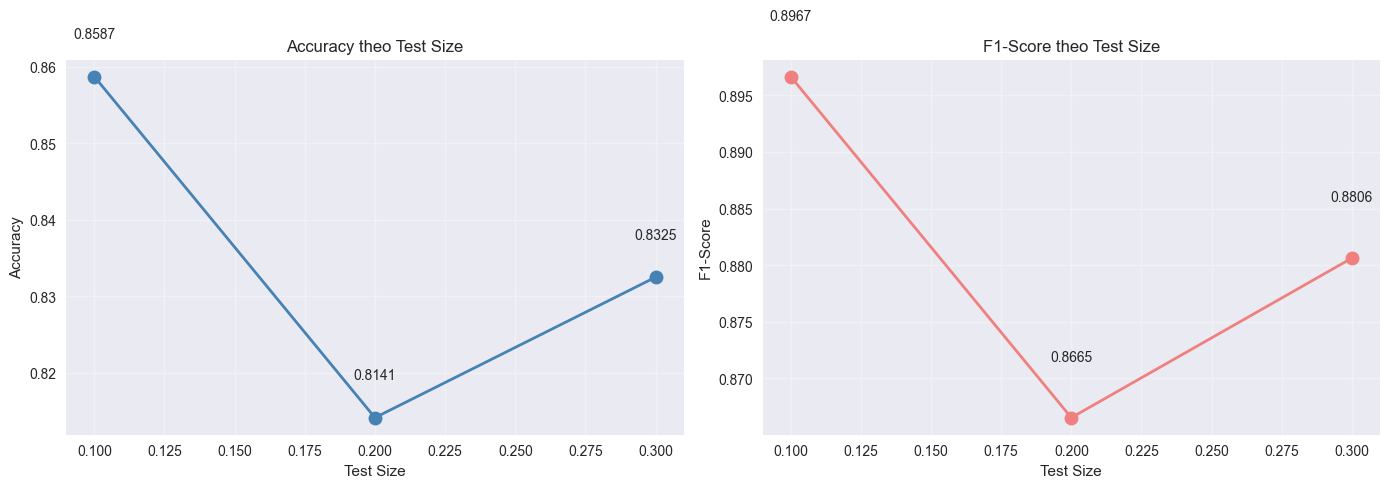

In [ ]:
print("=== THỰC NGHIỆM VỚI NHIỀU TỶ LỆ TRAIN/TEST ===")

test_size_results = {}

for test_size in test_sizes:
    print(f"\n--- Test Size = {test_size} ---")

    X_train_ts = datasets[test_size]['X_train']
    X_test_ts = datasets[test_size]['X_test']
    y_train_ts = datasets[test_size]['y_train']
    y_test_ts = datasets[test_size]['y_test']

    # Test với XGBoost (mô hình tốt nhất)
    xgb_model_ts = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    xgb_model_ts.fit(X_train_ts, y_train_ts)
    y_pred_ts = xgb_model_ts.predict(X_test_ts)

    accuracy = accuracy_score(y_test_ts, y_pred_ts)
    f1 = f1_score(y_test_ts, y_pred_ts)

    test_size_results[test_size] = {
        'accuracy': accuracy,
        'f1_score': f1
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Vẽ biểu đồ so sánh
test_sizes_list = list(test_size_results.keys())
accuracies = [test_size_results[ts]['accuracy'] for ts in test_sizes_list]
f1_scores = [test_size_results[ts]['f1_score'] for ts in test_sizes_list]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(test_sizes_list, accuracies, marker='o', linewidth=2, markersize=10, color='steelblue')
axes[0].set_xlabel('Test Size')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy theo Test Size')
axes[0].grid(True, alpha=0.3)
for i, acc in enumerate(accuracies):
    axes[0].text(test_sizes_list[i], acc + 0.005, f'{acc:.4f}', ha='center')

axes[1].plot(test_sizes_list, f1_scores, marker='o', linewidth=2, markersize=10, color='lightcoral')
axes[1].set_xlabel('Test Size')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score theo Test Size')
axes[1].grid(True, alpha=0.3)
for i, f1 in enumerate(f1_scores):
    axes[1].text(test_sizes_list[i], f1 + 0.005, f'{f1:.4f}', ha='center')

plt.tight_layout()
plt.show()


## 8. Kết luận và Nhận xét


In [ ]:
print("=== KẾT LUẬN ===")
print("\n1. MÔ HÌNH TỐT NHẤT:")
best_idx = comparison_df['Test Accuracy'].idxmax()
print(f"   - {comparison_df.loc[best_idx, 'Model']} với Test Accuracy = {comparison_df.loc[best_idx, 'Test Accuracy']:.4f}")

print("\n2. SO SÁNH CÁC MÔ HÌNH:")
print("   - Logistic Regression: Mô hình baseline đơn giản, dễ hiểu nhưng hiệu suất thấp hơn")
print("   - Decision Tree: Dễ giải thích nhưng dễ overfitting")
print("   - LightGBM & XGBoost: Gradient boosting models cho hiệu suất cao nhất")
print("     → XGBoost và LightGBM thường tốt hơn vì:")
print("       + Sử dụng ensemble learning (kết hợp nhiều cây quyết định)")
print("       + Có khả năng xử lý non-linear relationships tốt")
print("       + Có built-in regularization để tránh overfitting")

print("\n3. ĐẶC TRƯNG QUAN TRỌNG:")
print("   - alcohol: Đặc trưng quan trọng nhất, ảnh hưởng trực tiếp đến chất lượng")
print("   - volatile acidity: Axit dễ bay hơi, nếu cao sẽ làm giảm chất lượng")
print("   - sulphates: Giúp bảo quản và ảnh hưởng đến hương vị")

print("\n4. HƯỚNG PHÁT TRIỂN:")
print("   - Hyperparameter tuning với GridSearchCV hoặc RandomizedSearchCV")
print("   - Xử lý mất cân bằng lớp bằng SMOTE hoặc class weights")
print("   - Thử nghiệm với các mô hình khác: Random Forest, SVM, Neural Networks")
print("   - So sánh riêng biệt giữa wine đỏ và wine trắng")
print("   - Thử nghiệm với bài toán regression để dự đoán điểm quality chính xác")


=== KẾT LUẬN ===

1. MÔ HÌNH TỐT NHẤT:
   - LightGBM với Test Accuracy = 0.8217

2. SO SÁNH CÁC MÔ HÌNH:
   - Logistic Regression: Mô hình baseline đơn giản, dễ hiểu nhưng hiệu suất thấp hơn
   - Decision Tree: Dễ giải thích nhưng dễ overfitting
   - LightGBM & XGBoost: Gradient boosting models cho hiệu suất cao nhất
     → XGBoost và LightGBM thường tốt hơn vì:
       + Sử dụng ensemble learning (kết hợp nhiều cây quyết định)
       + Có khả năng xử lý non-linear relationships tốt
       + Có built-in regularization để tránh overfitting

3. ĐẶC TRƯNG QUAN TRỌNG:
   - alcohol: Đặc trưng quan trọng nhất, ảnh hưởng trực tiếp đến chất lượng
   - volatile acidity: Axit dễ bay hơi, nếu cao sẽ làm giảm chất lượng
   - sulphates: Giúp bảo quản và ảnh hưởng đến hương vị

4. HƯỚNG PHÁT TRIỂN:
   - Hyperparameter tuning với GridSearchCV hoặc RandomizedSearchCV
   - Xử lý mất cân bằng lớp bằng SMOTE hoặc class weights
   - Thử nghiệm với các mô hình khác: Random Forest, SVM, Neural Networks
   - 